La advertencia del cuadro siguiente es válida cuando no se aplica previamente un filtro paabanda entre mas o menos los 50 y los 10000 y además se disminuye el porcentaje de roll_off por debajo del 50%. En estos casos se nota una gran separación entre las manzanas y lo demás. En este caso se probó con un frame de 512.

DVERTENCIA: La verdad que esta medida tampoco hace nada

In [1]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve


In [2]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']

training_path    = '../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [3]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [4]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [5]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [6]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [7]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [8]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [9]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [10]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER  = band_energy_ratio(spec, split_frequency, sr)
        #BER /= np.max(BER)
        #feat = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        #frames = range(len(feat))
        #t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        #absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        #momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        #means = np.mean(feat)

        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)




**ROLL OFF**
- Media.

Se logra una buena separación con cortes en 100 y 8500 con un porcentaje de roll del 28% con un frame de 512

C:\Users\Juan\AppData\Local\Temp\ipykernel_4236\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


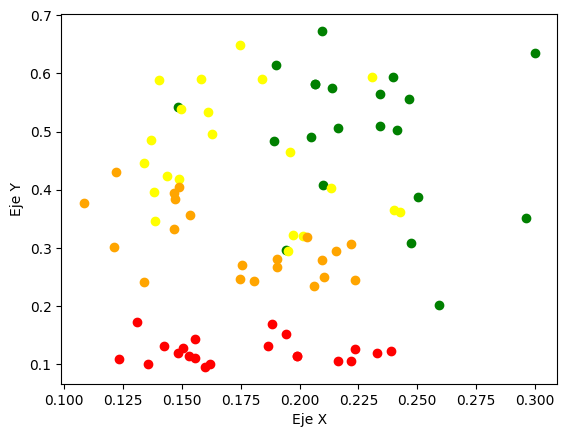

In [44]:
features = dict.fromkeys(fruit_types)
cuton = 100
cutoff = 8500
# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        signal = band_pass_filter(signal, sr, cuton, cutoff)
        roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
        roll_off /= np.max(np.abs(roll_off))


        feat = np.mean(np.abs(roll_off))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)


- RMS

C:\Users\Juan\AppData\Local\Temp\ipykernel_4236\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


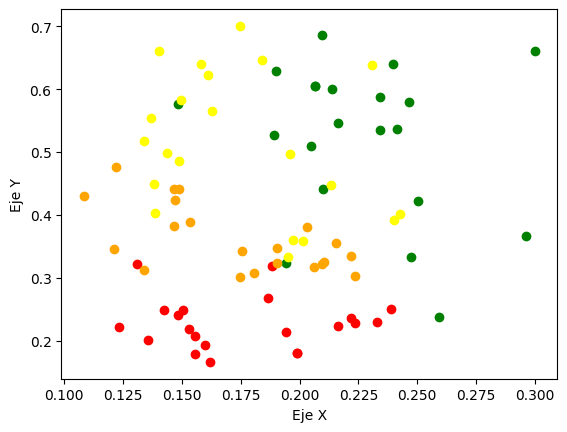

In [49]:
features = dict.fromkeys(fruit_types)
cuton = 100
cutoff = 8500

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))
        signal = band_pass_filter(signal, sr, cuton, cutoff)

        roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
        roll_off /= np.max(np.abs(roll_off))

        feat = np.sqrt(np.mean(roll_off**2))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)


- Máximo

C:\Users\Juan\AppData\Local\Temp\ipykernel_4236\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


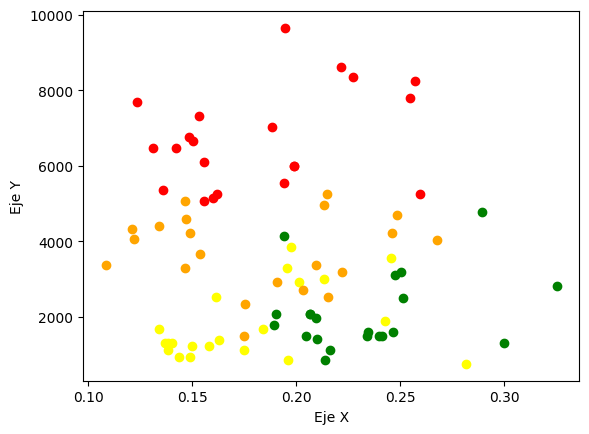

In [59]:
cutoff = 8500
cuton = 100
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.55)[0]
        feat = np.max(np.abs(roll_off))
        roll_off /= np.max(np.abs(roll_off))
        
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)



- Desviación estándar

C:\Users\Juan\AppData\Local\Temp\ipykernel_4236\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


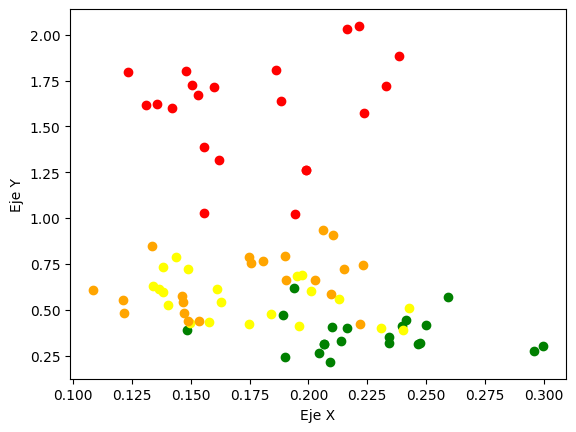

In [68]:
cutoff = 8500
cuton = 50
features = dict.fromkeys(fruit_types)


# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))
        signal = band_pass_filter(signal, sr, cuton, cutoff)

        roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
        roll_off /= np.max(np.abs(roll_off))
        feat = np.std(np.abs(roll_off))/np.mean(np.abs(roll_off))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)
